In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
sys.path.append("../")
import macrophages_analysis

In [2]:
raw_data_path = '../../20x_datasets/Raw_data/'
preprocessed_data_path = '../../20x_datasets/Preprocessed_data/'

# Basic preprocessing

## Prepocessing of 20x CD86 P4G4 nucleus data

In [3]:
# read CD86 P4G4 nucleus data
nuclei_m1 = pd.read_csv(raw_data_path + "20x_nuclei_P4G4_CD68_M1_NucleiObj.csv")
nuclei_m2_nt = pd.read_csv(raw_data_path + "20x_nuclei_P4G4_CD68_M2_NT_NucleiObj.csv")

# set cell type based on image from which data were taken
nuclei_m1['CellType'] = 'M1'
nuclei_m2_nt.loc[nuclei_m2_nt['ImageNumber'].isin([1,2,3,4]), 'CellType'] = 'M2'
nuclei_m2_nt.loc[nuclei_m2_nt['ImageNumber'].isin([5,6,7]), 'CellType'] = 'NT'
nucleus_dataset_p4g4 = nuclei_m1.merge(nuclei_m2_nt, how='outer')

## Prepocessing of 20x CD86 Smooth nucleus data

In [4]:
# read CD86 Smooth nucleus data
nucleus_dataset_smooth = pd.read_csv(raw_data_path + '20x_nuclei_Smooth_CD86_M1_M2_NT_NucleiObj.csv')

# set cell type based on image from which data were taken
nucleus_dataset_smooth.loc[nucleus_dataset_smooth['ImageNumber'].isin([1,2,3]), 'CellType'] = 'M1'
nucleus_dataset_smooth.loc[nucleus_dataset_smooth['ImageNumber'].isin([4,5,6]), 'CellType'] = 'M2'
nucleus_dataset_smooth.loc[nucleus_dataset_smooth['ImageNumber'].isin([7,8,9]), 'CellType'] = 'NT'

## Prepocessing of 20x CD86 TCPS nucleus data

In [5]:
# read CD86 TCPS nucleus data
nucleus_dataset_tcps = pd.read_csv(raw_data_path + '20x_nuclei_TCPS_CD86_M1_M2_NT_NucleiObj.csv')

# set cell type based on image from which data were taken
nucleus_dataset_tcps.loc[nucleus_dataset_tcps['ImageNumber'].isin([1,2,3,4,5]), 'CellType'] = 'M1'
nucleus_dataset_tcps.loc[nucleus_dataset_tcps['ImageNumber'].isin([6,7,8]), 'CellType'] = 'M2'
nucleus_dataset_tcps.loc[nucleus_dataset_tcps['ImageNumber'].isin([9,10,11]), 'CellType'] = 'NT'

In [6]:
num_datasets = 3
nucleus_datasets = [nucleus_dataset_p4g4,
                   nucleus_dataset_smooth,
                   nucleus_dataset_tcps]

clean_datasets = []
for i in range(num_datasets):
    dataset = nucleus_datasets[i].copy()
    dataset.drop(['ImageNumber', 'ObjectNumber', 'Number_Object_Number'], axis=1, inplace=True)
    dataset = dataset.loc[:, (nucleus_datasets[i] != nucleus_datasets[i].iloc[0]).any()]
    dataset = macrophages_analysis.remove_outliers(dataset, 'Intensity_IntegratedIntensity_Nuclei', method='percentile')
    clean_datasets.append(dataset)

<Axes: title={'center': 'Intensity_IntegratedIntensity_Nuclei'}, xlabel='CellType'>

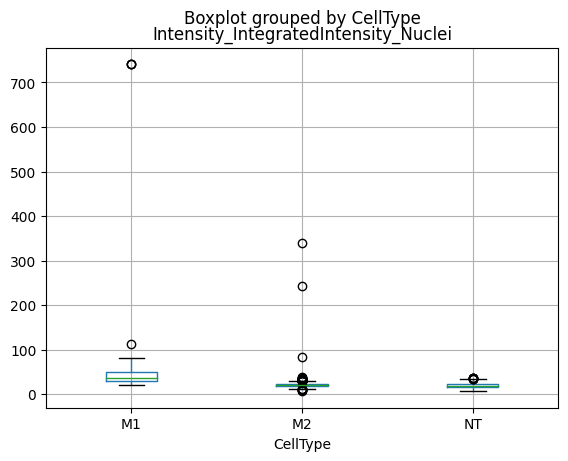

In [7]:
nucleus_datasets[0].boxplot('Intensity_IntegratedIntensity_Nuclei', by='CellType')

<Axes: title={'center': 'Intensity_IntegratedIntensity_Nuclei'}, xlabel='CellType'>

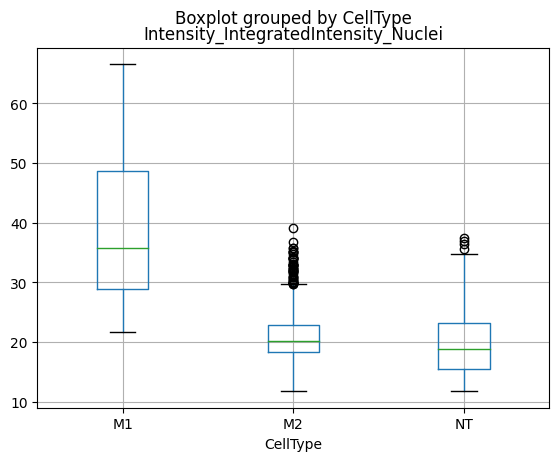

In [8]:
clean_datasets[0].boxplot('Intensity_IntegratedIntensity_Nuclei', by='CellType')

# Dimesionality reduction

In [9]:
#read features selected in preprocessin pipeline for CD86
features = macrophages_analysis.read_features('features.txt')


for i in range(num_datasets):
    dataset = clean_datasets[i].copy()
    dataset = macrophages_analysis.remove_correlated_features(dataset, 0.9)
    
    nucleus_classifier, test_data = macrophages_analysis.make_nucleus_classifier(dataset)
    
    best_features = macrophages_analysis.get_best_features(nucleus_classifier, dataset.drop('CellType', axis=1), 30)
    features = pd.concat([features, best_features])
    
features.drop_duplicates(subset='Feature', inplace=True)
# features.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 40))   
resulting_features = features.Feature.to_list()
resulting_features.append('CellType')
print('Length of best_features', len(resulting_features))

Amount of correlated features to drop: 113
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8827946127946127
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.892665173666059
Amount of correlated features to drop: 129
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8991764705882355
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8831195526378078
Amount of correlated features to drop: 128
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8858901515151516
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8849913253838226
Length of best_features 59


In [11]:
processed_nucleus_datasets = []

for i in range(num_datasets):
    
    dataset = clean_datasets[i].copy()
    dataset = dataset.loc[:, resulting_features]
    processed_nucleus_datasets.append(dataset)
    nucleus_classifier, test_data = macrophages_analysis.make_nucleus_classifier(dataset)
    
processed_nucleus_datasets[0].to_csv(preprocessed_data_path + 'clean_20x_CD68_P4G4_nucleus_dataset.csv', index=False)
# processed_nucleus_datasets[1].to_csv(preprocessed_data_path + 'clean_20x_CD68_Smooth_nucleus_dataset.csv', index=False)
# processed_nucleus_datasets[2].to_csv(preprocessed_data_path + 'clean_20x_CD68_TCPS_nucleus_dataset.csv', index=False)

Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8863973063973063
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8941714549275781
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.9447450980392155
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.9293150282476106
Mean accuracy of XGBClassifier (10-fold cross-validation) 0.8981060606060606
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.8962660741859816
